In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
util = '/content/drive/MyDrive/'

In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
import warnings
import sys
warnings.filterwarnings('ignore')
import torchvision
import torch.nn as nn
sys.path.append(util)
from ipywidgets import interact
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from util import CLASS_NAME_TO_ID, visualize, save_model
from collections import defaultdict
from tqdm import tqdm
from torchvision.ops import nms
from albumentations.pytorch import ToTensorV2

In [ ]:
data_dir = '/content/drive/MyDrive/Day2 computervision/DataSet'
data_dir_train = '/content/drive/MyDrive/Day2 computervision/DataSet/train'
data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))

In [ ]:
data_df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24057,fff2b15ad6007d0e,activemil,Truck,1,0.277344,0.622656,0.226389,0.859722,0,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
24058,fff376d20410e4c9,xclick,Bus,1,0.295625,0.558750,0.306667,0.397500,1,0,...,1,0,0.424375,0.316250,0.295625,0.558750,0.306667,0.397500,0.382500,0.335833
24059,fff376d20410e4c9,xclick,Bus,1,0.348125,0.701250,0.423333,0.744167,0,0,...,1,0,0.478750,0.493125,0.348125,0.701250,0.423333,0.744167,0.537500,0.523333
24060,fffde5953a818927,xclick,Bus,1,0.277500,0.605625,0.565000,0.795833,0,0,...,0,0,0.488125,0.277500,0.517500,0.605625,0.565000,0.670000,0.795833,0.704167


In [ ]:
data_df['LabelName'].value_counts()

Truck    12135
Bus      11927
Name: LabelName, dtype: int64

In [ ]:
index = 0   # 리스트에서 어떤 이미지 파일을 선택할지를 나타냄
image_files = [fn for fn in os.listdir(data_dir_train) if fn.endswith('jpg')]
# 지정한 디렉토리 내의 모든 파일과 폴더의 이름중 'jpg'로 끝나는 이름만 리스트에추가
image_file = image_files[index]
image_file
# 0번에 해당하는 파일가지고옴

'cdbf2b2aaf696642.jpg'

In [ ]:
image_path = os.path.join(data_dir_train, image_file) # 이미지 파일의 전체 경로 저장
image_path

'/content/drive/MyDrive/Day2 computervision/DataSet/train/cdbf2b2aaf696642.jpg'

In [ ]:
# 이미지 불러들이기
image = cv2.imread(image_path) #  OpenCV 라이브러리를 사용하여 이미지 파일 읽기
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # OpenCV 라이브러리를 사용하여 이미지의 컬러 채널을 변경
image.shape

(192, 256, 3)

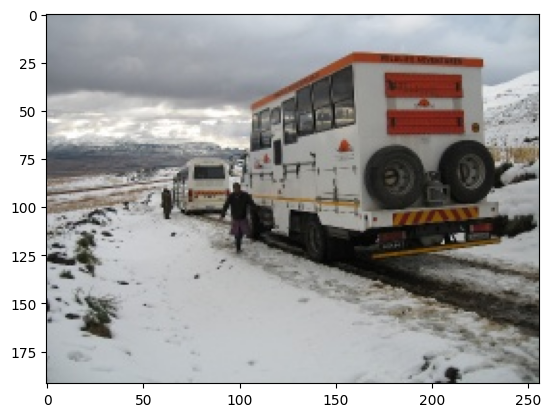

In [ ]:
plt.imshow(image)

In [ ]:
image_id = image_file.split('.')[0]
image_id

'cdbf2b2aaf696642'

In [ ]:
meta_data = data_df[data_df['ImageID']== image_id]
meta_data

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
19694,cdbf2b2aaf696642,activemil,Truck,1,0.361875,0.892500,0.196667,0.684167,0,0,...,0,0,-1.00000,-1.00000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.0000
19695,cdbf2b2aaf696642,xclick,Truck,1,0.246250,0.375625,0.392500,0.540833,0,0,...,0,0,0.32375,0.24625,0.310625,0.375625,0.3975,0.471667,0.540833,0.3925


In [ ]:
cate_names = meta_data['LabelName'].values
cate_names
# 라벨 네임 뽑아오기

array(['Truck', 'Truck'], dtype=object)

In [ ]:
bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
bboxes

array([[0.361875, 0.8925  , 0.196667, 0.684167],
       [0.24625 , 0.375625, 0.3925  , 0.540833]])

In [ ]:
img_H, img_W, _ = image.shape
img_H, img_W

(192, 256)

In [ ]:
class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
class_ids

[1, 1]

In [ ]:
unnorm_bboxes = bboxes.copy()

unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[: , [2, 1]]
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)

# X_cen, Y_cen, W, H
unnorm_bboxes

array([[0.6271875, 0.440417 , 0.530625 , 0.4875   ],
       [0.3109375, 0.4666665, 0.129375 , 0.148333 ]])

In [ ]:
unnorm_bboxes[:, [0, 2]] *= img_W
unnorm_bboxes[:, [1, 3]] *= img_H
unnorm_bboxes

array([[160.56    ,  84.560064, 135.84    ,  93.6     ],
       [ 79.6     ,  89.599968,  33.12    ,  28.479936]])

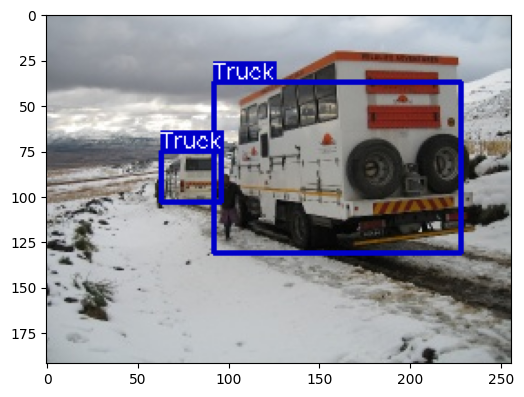

In [ ]:
canvas = visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [ ]:
@interact(index=(0, len(image_files)-1))

def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join('/content/drive/MyDrive/Day2 computervision/DataSet', image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 위코드에서 가져오기
    image_id = image_file.split('.')[0]
    meta_data = data_df[data_df['ImageID'] == image_id]
    cate_names = meta_data['LabelName'].values
    bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
    img_H, img_W, _ = image.shape
    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)
    unnorm_bboxes[:, [0, 2]] *= img_W
    unnorm_bboxes[:, [1, 3]] *= img_H
    canvas = visualize(image, unnorm_bboxes, class_ids)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [ ]:
class Detection_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.phase = phase
        self.data_df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith('jpg')]
        self.transformer = transformer

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)

        if self.transformer:
            transformed_data = self.transformer(image=image, bboxes=bboxes, class_ids=class_ids)
            image = transformed_data['image']
            bboxes = np.array(transformed_data['bboxes'])
            class_ids = np.array(transformed_data['class_ids'])

        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)

        return image, target, filename

    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)  # './DataSet/train/filename'
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image

    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = data_df[data_df['ImageID'] == image_id]
        cate_names = meta_data['LabelName'].values
        class_ids = np.array([CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names])

        bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
        bboxes[:, [1, 2]] = bboxes[:, [2, 1]]
        bboxes[:, 2:4] -= bboxes[:, 0:2]
        bboxes[:, 0:2] += (bboxes[:, 2:4] / 2)
        return bboxes, class_ids

In [ ]:
data_dir = '/content/drive/MyDrive/Day2 computervision/DataSet'
dataset = Detection_dataset(data_dir = data_dir, phase='train', transformer=None)

In [ ]:
dataset[0]

(array([[[143, 150, 158],
         [145, 152, 160],
         [147, 154, 162],
         ...,
         [177, 187, 189],
         [175, 185, 187],
         [175, 185, 187]],
 
        [[146, 153, 161],
         [147, 154, 162],
         [149, 156, 164],
         ...,
         [179, 189, 191],
         [177, 187, 189],
         [176, 186, 188]],
 
        [[149, 156, 164],
         [150, 157, 165],
         [151, 158, 166],
         ...,
         [182, 191, 196],
         [179, 188, 193],
         [177, 186, 191]],
 
        ...,
 
        [[138, 143, 147],
         [158, 163, 167],
         [164, 172, 175],
         ...,
         [139, 144, 140],
         [137, 142, 138],
         [125, 130, 126]],
 
        [[131, 136, 140],
         [151, 156, 160],
         [157, 165, 168],
         ...,
         [129, 135, 131],
         [140, 147, 140],
         [139, 146, 139]],
 
        [[147, 152, 156],
         [156, 161, 165],
         [157, 165, 168],
         ...,
         [119, 125, 121],
  

In [ ]:
index = 20
image, target, filename = dataset[index]

In [ ]:
target, filename

(array([[0.043457 , 0.4661455, 0.086914 , 0.270833 , 0.       ],
        [0.2509765, 0.460937 , 0.476563 , 0.28125  , 0.       ],
        [0.6982425, 0.3847655, 0.501953 , 0.355469 , 0.       ],
        [0.572754 , 0.454427 , 0.21582  , 0.257812 , 0.       ]]),
 'cd8c15a57076dda4.jpg')

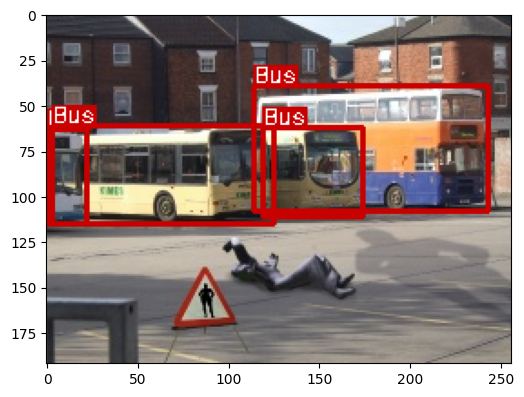

In [ ]:
bboxes = target[:, 0:4]
class_ids = target[:, 4]

img_H, img_W, _ = image.shape
bboxes[:, [0, 2]] *= img_W
bboxes[:, [1, 3]] *= img_H

canvas = visualize(image, bboxes, class_ids)

plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [ ]:
transformed_dataset = Detection_dataset(data_dir=data_dir, phase='train')
transformed_dataset[3]

(array([[[66, 53, 36],
         [65, 52, 35],
         [65, 52, 35],
         ...,
         [42, 22, 15],
         [43, 19,  9],
         [42, 18,  6]],
 
        [[65, 52, 35],
         [64, 51, 34],
         [64, 51, 34],
         ...,
         [40, 20, 13],
         [41, 19,  8],
         [35, 13,  0]],
 
        [[65, 52, 35],
         [65, 52, 35],
         [66, 53, 36],
         ...,
         [33, 12,  7],
         [33, 13,  2],
         [32, 13,  0]],
 
        ...,
 
        [[74, 56, 36],
         [74, 56, 36],
         [75, 57, 37],
         ...,
         [52, 38, 27],
         [52, 38, 27],
         [51, 37, 26]],
 
        [[76, 58, 38],
         [76, 58, 38],
         [77, 59, 39],
         ...,
         [54, 40, 29],
         [54, 40, 29],
         [52, 38, 27]],
 
        [[77, 59, 39],
         [77, 59, 39],
         [78, 60, 40],
         ...,
         [51, 37, 26],
         [53, 39, 28],
         [52, 38, 27]]], dtype=uint8),
 array([[0.5584375, 0.4608335, 0.808125 , 

In [ ]:
@interact(index=(0, len(transformed_dataset) - 1))
def show_sample(index=0):
    image, target, filename = transformed_dataset[index]

    bboxes = target[:, 0:4]
    class_ids = target[:, 4]

    _, img_H, img_W = image.shape

    bboxes[:, [0, 2]] *= img_W
    bboxes[:, [1, 3]] *= img_H

    np_image = make_grid(image, normalize=True).cpu().permute(1, 2, 0).numpy()
    canvas = visualize(np_image, bboxes, class_ids)

    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

### Albumentations
* 이미지 데이터 증강 모듈
* 다양한 증강 기법: 화전, 이동, 크기조정, 반전, 색상 변환
* 빠른 성능
* API를 제공

In [ ]:
IMAGE_SIZE = 448

transformer = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ],
    bbox_params = A.BboxParams(format='yolo', label_fields=['class_ids'])
)

In [ ]:
transformed_dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)
transformed_dataset[3]

(tensor([[[-0.9877, -1.0048, -1.0048,  ..., -1.3815, -1.3987, -1.3987],
          [-0.9877, -1.0048, -1.0048,  ..., -1.3815, -1.3987, -1.4158],
          [-1.0048, -1.0048, -1.0219,  ..., -1.4158, -1.4500, -1.4672],
          ...,
          [-0.8164, -0.8164, -0.8164,  ..., -1.2103, -1.2274, -1.2274],
          [-0.7993, -0.7993, -0.7993,  ..., -1.2103, -1.2274, -1.2274],
          [-0.7993, -0.7993, -0.7993,  ..., -1.2103, -1.2274, -1.2274]],
 
         [[-1.1078, -1.1078, -1.1253,  ..., -1.7031, -1.7206, -1.7206],
          [-1.1078, -1.1253, -1.1253,  ..., -1.7031, -1.7206, -1.7381],
          [-1.1253, -1.1253, -1.1429,  ..., -1.7031, -1.7556, -1.7731],
          ...,
          [-1.0203, -1.0203, -1.0203,  ..., -1.3529, -1.3704, -1.3704],
          [-1.0028, -1.0028, -1.0028,  ..., -1.3529, -1.3704, -1.3704],
          [-1.0028, -1.0028, -1.0028,  ..., -1.3529, -1.3704, -1.3704]],
 
         [[-1.1770, -1.1944, -1.1944,  ..., -1.6476, -1.6824, -1.6999],
          [-1.1770, -1.1944,

In [ ]:
def collate_fn(batch): # dataloader에 들어가는 속성값
    image_list = []
    target_list = []
    filename_list = []

    for img, target, filename in batch: # batch로 나뉘어진 다음에 들어온다.
        image_list.append(img)
        target_list.append(target)
        filename_list.append(filename)
    return torch.stack(image_list, dim=0), target_list, filename_list

In [ ]:
BATCH_SIZE=8

trainset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn = collate_fn, shuffle=True)

In [ ]:
for index, batch in enumerate(train_loader):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    if index == 0:
        break

print(targets, end='\n')
print(filenames)

[array([[0.499375 , 0.4841665, 0.99875  , 0.968333 , 0.       ]]), array([[0.4875  , 0.641386, 0.6775  , 0.61985 , 1.      ]]), array([[0.404375, 0.530957, 0.78375 , 0.93621 , 1.      ]]), array([[0.40125  , 0.286181 , 0.1675   , 0.131652 , 1.       ],
       [0.11125  , 0.2810455, 0.04875  , 0.138189 , 1.       ]]), array([[0.5821875, 0.5182925, 0.774375 , 0.963415 , 1.       ]]), array([[0.5231395, 0.444758 , 0.906191 , 0.805646 , 1.       ],
       [0.1216385, 0.1592745, 0.243277 , 0.241129 , 1.       ]]), array([[0.898125 , 0.2884445, 0.2025   , 0.180445 , 0.       ]]), array([[0.5085365, 0.5666665, 0.982927 , 0.866667 , 1.       ]])]
['986dca408caf8af3.jpg', '89315bf434722140.jpg', '79f6b3b152de5f61.jpg', '5a0138c2d07c212c.jpg', '49a5f5a25ffd932b.jpg', '4356a4ecc267f372.jpg', '114ba8aec8c060bd.jpg', '57472d3231b8ef88.jpg']


In [ ]:
def build_dataloader(data_dir, batch_size=4, image_size=448):
    transformer = A.Compose([
        A.Resize(height = image_size, width = image_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
        ToTensorV2(),
        ],
        bbox_params = A.BboxParams(format='yolo', label_fields=['class_ids'])
        # bbox_params을 사용하면 bounding box에도 옵션을 줄 수 있다.
    )

    dataloaders = {}
    train_dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)
    dataloaders['train'] = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn = collate_fn, shuffle=True)

    val_dataset = Detection_dataset(data_dir=data_dir, phase='val', transformer=transformer)
    dataloaders['val'] = DataLoader(val_dataset, batch_size=1, collate_fn = collate_fn, shuffle=False)

    return dataloaders

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
layers = [m for m in resnet50.children()]
layers

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [ ]:
len(layers)

10

In [ ]:
layers[-1]

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
layers[-2]

AdaptiveAvgPool2d(output_size=(1, 1))

In [ ]:
testnet = nn.Sequential(*layers[:-2]) #Sequential로 감싼 레이어 마지막 2개를 제외한 모든 레이어를 가지고옴
testnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
class DetectionNet(nn.Module):
    """The layers added on for detection as described in the paper."""

    def __init__(self, in_channels):
        super().__init__()

        inner_channels = 1024
        self.depth = 5 * 2 + 2
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, stride=2, padding=1),   # (Ch, 14, 14) -> (Ch, 7, 7)
            nn.LeakyReLU(negative_slope=0.1),

            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Flatten(),

            nn.Linear(7 * 7 * inner_channels, 4096),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Linear(4096, 4)  # Change this to output 4-dimensional tensor
        )

    def forward(self, x):
        predictions = self.model.forward(x)
        # Reshape predictions into (x_min, y_min, x_max, y_max) format
        predictions = torch.reshape(predictions, (-1, 2, 2))  # Assuming 2 predictions per axis
        return predictions


In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = tuple(args)

    def forward(self, x):
        return torch.reshape(x, (-1, *self.shape))

In [ ]:
model = nn.Sequential(
    testnet,
    Reshape(2048, 14, 14),
    DetectionNet(2048)
)


In [ ]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [ ]:
data_dir = '/content/drive/MyDrive/Day2 computervision/DataSet'
dloaders = build_dataloader(data_dir)
for index, batch in enumerate(dloaders['train']):
    targets = batch[1]
    print(targets[1])
    label = [i[0][-1] for i in targets]
    print(label)
    if index == 0:
        break

[[0.7707315 0.5788615 0.436585  0.517073  1.       ]
 [0.4115855 0.478049  0.581707  0.84878   1.       ]]
[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]


In [ ]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming model is defined somewhere above this code
# model = ...

# Define the number of training epochs
phase = 'train'
num_epochs = 30
checkpoint_interval = 30

# Move model and criterion to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    num_samples = 0

    for index, batch in enumerate(dloaders[phase]):
        images = batch[0].to(device)
        targets = batch[1]
        filenames = batch[2]

        label = [i[0][-1] for i in targets]
        bbox = [i[0][0:4] for i in targets]

        batch_loss = 0.0
        num_samples += len(images)

        optimizer.zero_grad()  # Clear gradients

        # Loop through each image and its corresponding label and bbox
        for image, label, true_bbox in zip(images, label, bbox):
            # Pass the image through the model
            features = model(image.unsqueeze(0))  # Adding batch dimension
            predictions = features  # Predictions directly from features

            # Convert true_bbox to a tensor and reshape to match predictions
            true_bbox_tensor = torch.tensor(true_bbox, dtype=torch.float32, device=device)
            true_bbox_tensor = true_bbox_tensor.view(predictions.shape)

            # Calculate the Mean Squared Error loss
            loss_bbox = criterion(predictions, true_bbox_tensor)
            batch_loss += loss_bbox

        batch_loss /= len(images)  # Calculate average loss for the batch
        batch_loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += batch_loss.item()

    average_loss = total_loss / num_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")

    # Save the model checkpoint
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = f"model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)

Epoch [1/30], Average Loss: 21007.2987
Epoch [2/30], Average Loss: 0.0983
Epoch [3/30], Average Loss: 0.4143
Epoch [4/30], Average Loss: 0.2604
Epoch [5/30], Average Loss: 0.1053
Epoch [6/30], Average Loss: 0.0545
Epoch [7/30], Average Loss: 0.0313
Epoch [8/30], Average Loss: 7850079661046.6641
Epoch [9/30], Average Loss: 179481690.6429
Epoch [10/30], Average Loss: 75649063.3917
Epoch [11/30], Average Loss: 50980655.8284
Epoch [12/30], Average Loss: 37833561.2184
Epoch [13/30], Average Loss: 27601506.4730
Epoch [14/30], Average Loss: 12782303.6234
Epoch [15/30], Average Loss: 797126711677.1674
Epoch [16/30], Average Loss: 177131183.5149
Epoch [17/30], Average Loss: 89821042.5816
Epoch [18/30], Average Loss: 33106202.0855
Epoch [19/30], Average Loss: 168715944653.3588
Epoch [20/30], Average Loss: 56990250.7550
Epoch [21/30], Average Loss: 22369379.5081
Epoch [22/30], Average Loss: 19628631.3380


error: ignored